# The Dow Jones Industrial Average and Its 30 Components

## Downloading Dow componentms datasets from Quandl

In [3]:
import quandl

QUANDL_API_KEY = 'BCzkk3NDWt7H9yjzx-DY'  # Your own Quandl key here
quandl.ApiConfig.api_key = QUANDL_API_KEY

SYMBOLS = [
    'AAPL','MMM', 'AXP', 'BA', 'CAT',
    'CVX', 'CSCO', 'KO', 'DD', 'XOM',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ',
    'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'UNH', 'UTX', 'TRV', 
    'VZ', 'V', 'WMT', 'WBA', 'DIS',
]

wiki_symbols = ['WIKI/%s'%symbol for symbol in SYMBOLS]
df_components = quandl.get(
    wiki_symbols, 
    start_date='2017-01-01', 
    end_date='2017-12-31', 
    column_index=11)
df_components.columns = SYMBOLS  # Renaming the columns

In [4]:
filled_df_components = df_components.fillna(method='ffill')
daily_df_components = filled_df_components.resample('24h').ffill()
daily_df_components = daily_df_components.fillna(method='bfill')

## Downloading DJIA Dataset from Alpha Vantage

In [5]:
"""
Download the all-time DJIA dataset
"""
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df, meta_data = ts.get_daily_adjusted(symbol='^DJI', outputsize='full')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4764 entries, 2000-01-03 to 2018-12-07
Data columns (total 8 columns):
1. open                 4764 non-null float64
2. high                 4764 non-null float64
3. low                  4764 non-null float64
4. close                4764 non-null float64
5. adjusted close       4764 non-null float64
6. volume               4764 non-null float64
7. dividend amount      4764 non-null float64
8. split coefficient    4764 non-null float64
dtypes: float64(8)
memory usage: 316.4+ KB


In [7]:
df.index

Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2018-11-23', '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29',
       '2018-11-30', '2018-12-03', '2018-12-04', '2018-12-06', '2018-12-07'],
      dtype='object', name='date', length=4764)

In [8]:
import pandas as pd

# Prepare the dataframe
df_dji = pd.DataFrame(df['5. adjusted close'])
df_dji.columns = ['DJIA']
df_dji.index = pd.to_datetime(df_dji.index)

# Trim the new dataframe and resample
djia_2017 = pd.DataFrame(df_dji.loc['2017-01-01':'2017-12-31'])
djia_2017 = djia_2017.resample('24h').ffill()

# Applying a Kernel Principal Component Analysis

## Finding Eigenvectors and Eigenvalues

In [11]:
from sklearn.decomposition import KernelPCA

fn_z_score = lambda x: (x - x.mean()) / x.std()

df_z_components = daily_df_components.apply(fn_z_score)
fitted_pca = KernelPCA().fit(df_z_components)

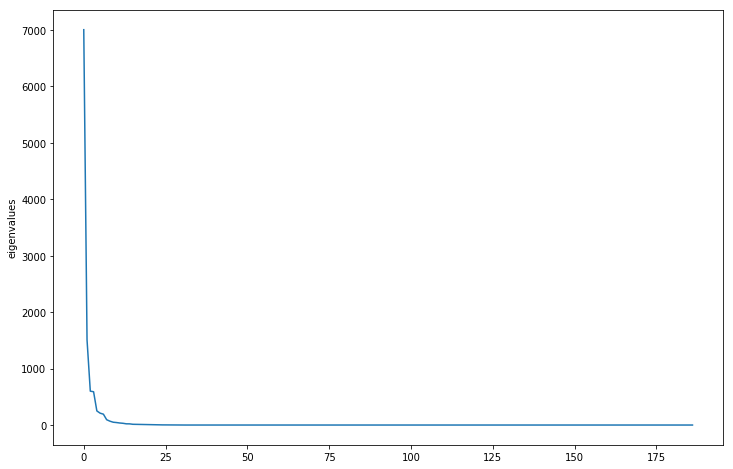

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,8)
plt.plot(fitted_pca.lambdas_)
plt.ylabel('eigenvalues')
plt.show();

In [13]:
fn_weighted_avg = lambda x: x / x.sum()
weighted_values = fn_weighted_avg(fitted_pca.lambdas_)[:5]

In [14]:
print(weighted_values)

[0.64863002 0.13966718 0.05558246 0.05461861 0.02313883]


In [16]:
weighted_values.sum()

0.9216371041932268

## Reconstructing the Dow Index with PCA

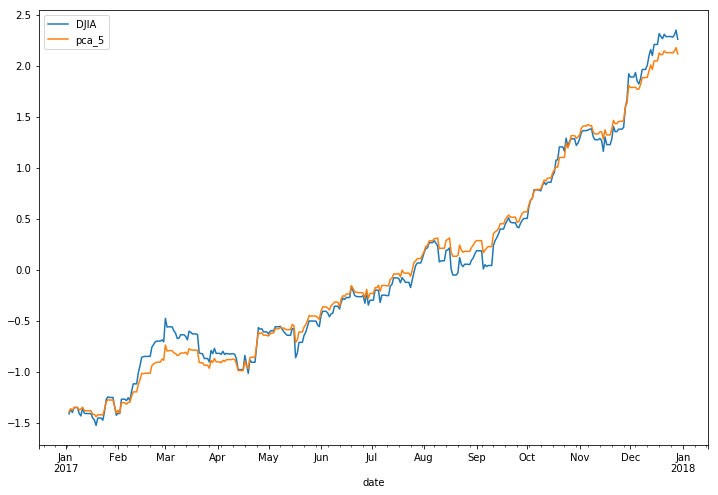

In [18]:
import numpy as np

kernel_pca = KernelPCA(n_components=5).fit(df_z_components)
pca_5 = kernel_pca.transform(-daily_df_components)

weights = fn_weighted_avg(kernel_pca.lambdas_)
reconstructed_values = np.dot(pca_5, weights)

# Combine DJIA and PCA index for comparison
df_combined = djia_2017.copy()
df_combined['pca_5'] = reconstructed_values
df_combined = df_combined.apply(fn_z_score)
df_combined.plot(figsize=(12, 8));

# Analyzing a time series with trend

In [21]:
import quandl

QUANDL_API_KEY = 'BCzkk3NDWt7H9yjzx-DY'  # Your Quandl key here
quandl.ApiConfig.api_key = QUANDL_API_KEY

df = quandl.get(
    'CHRIS/CME_GC1', 
    column_index=6,
    collapse='monthly',
    start_date='2000-01-01')

In [22]:
df.head()

,Settle
Date,
2000-01-31,283.2
2000-02-29,294.2
2000-03-31,278.4
2000-04-30,274.7
2000-05-31,271.7


In [23]:
df_settle = df['Settle'].resample('MS').ffill().dropna()

df_rolling = df_settle.rolling(12)
df_mean = df_rolling.mean()
df_std = df_rolling.std()

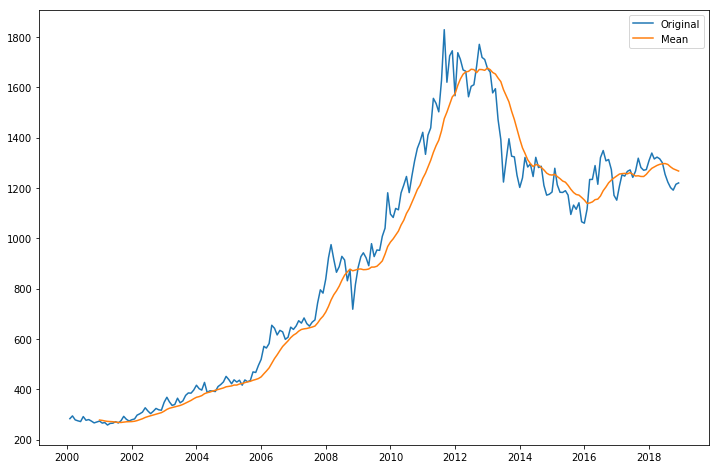

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(df_settle, label='Original')
plt.plot(df_mean, label='Mean')
plt.legend();

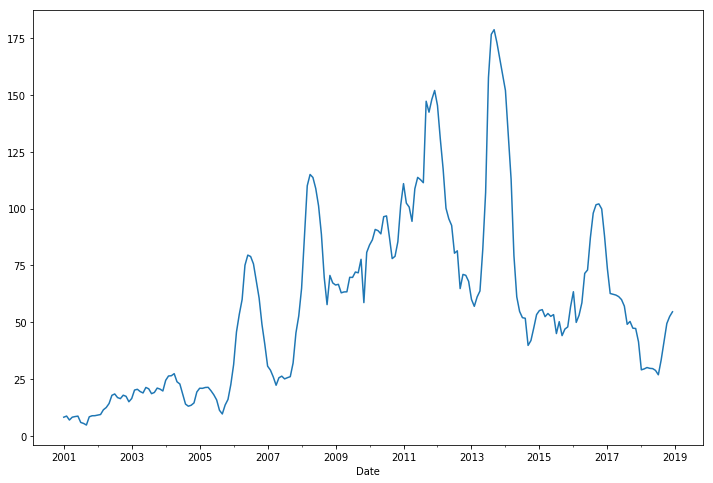

In [26]:
df_std.plot(figsize=(12, 8));

In [27]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_settle)
print('ADF statistic: ',  result[0])
print('p-value:', result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -1.4017828015895548
p-value: 0.5814211232134314
Critical value (1%): -3.461
Critical value (5%): -2.875
Critical value (10%): -2.574


# Making a time series stationary

## Detrending

In [29]:
import numpy as np

df_log = np.log(df_settle)

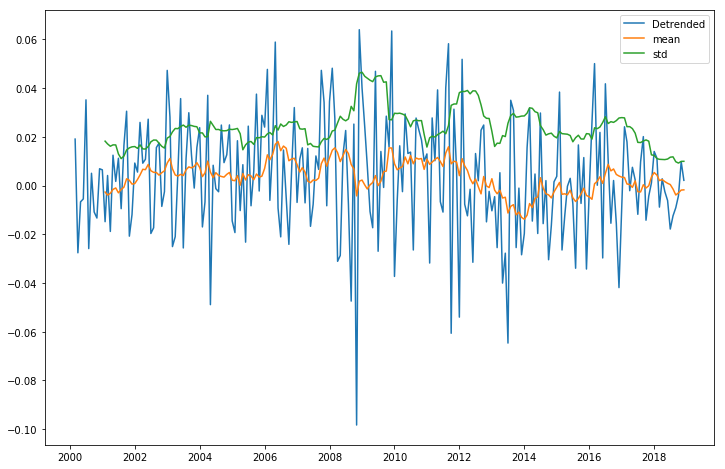

In [30]:
df_log_ma= df_log.rolling(2).mean()
df_detrend = df_log - df_log_ma
df_detrend.dropna(inplace=True)

# Mean and standard deviation of detrended data
df_detrend_rolling = df_detrend.rolling(12)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(df_detrend, label='Detrended')
plt.plot(df_detrend_ma, label='mean')
plt.plot(df_detrend_std, label='std')
plt.legend(loc='upper right');

In [31]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_detrend)
print('ADF statistic: ', result[0])
print('p-value: %.5f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -17.04239232215001
p-value: 0.00000
Critical value (1%): -3.460
Critical value (5%): -2.874
Critical value (10%): -2.574


## Removing trend by differencing

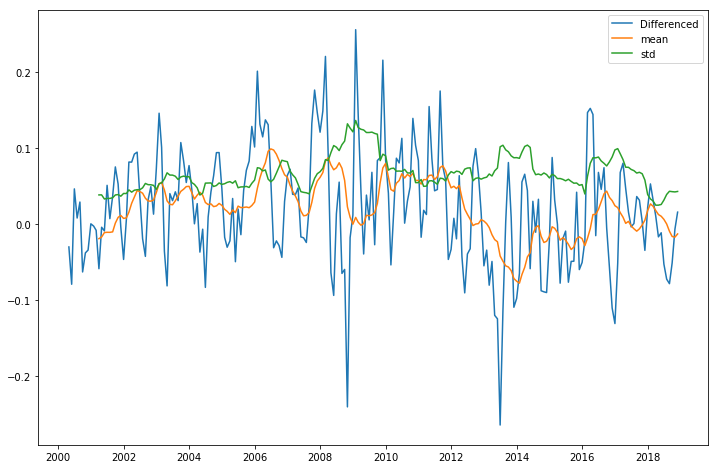

In [32]:
df_log_diff = df_log.diff(periods=3).dropna()

# Mean and standard deviation of differenced data
df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

# Plot the stationary data
plt.figure(figsize=(12, 8))
plt.plot(df_log_diff, label='Differenced')
plt.plot(df_diff_ma, label='mean')
plt.plot(df_diff_std, label='std')
plt.legend(loc='upper right');

In [33]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_log_diff)

print('ADF statistic:', result[0])
print('p-value: %.5f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic: -2.931684356800213
p-value: 0.04179
Critical value (1%): -3.462
Critical value (5%): -2.875
Critical value (10%): -2.574


## Seasonal Decomposing

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(df_log.dropna(), freq=12)

df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

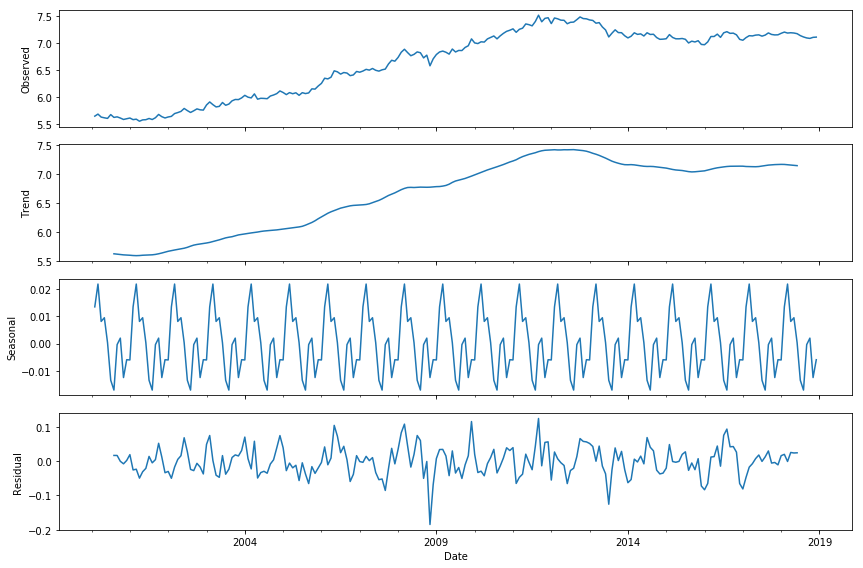

In [36]:
plt.rcParams["figure.figsize"] = (12, 8)
fig = decompose_result.plot()

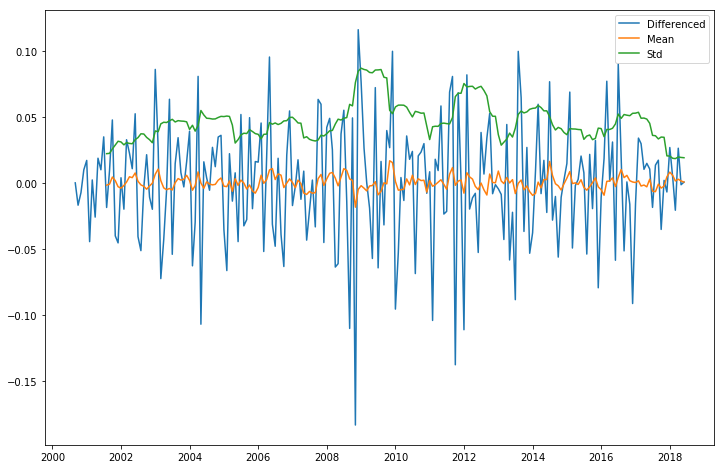

In [37]:
df_log_diff = df_residual.diff().dropna()

# Mean and standard deviation of differenced data
df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

# Plot the stationary data
plt.figure(figsize=(12, 8))
plt.plot(df_log_diff, label='Differenced')
plt.plot(df_diff_ma, label='Mean')
plt.plot(df_diff_std, label='Std')
plt.legend();

In [39]:
result = adfuller(df_residual.dropna())

print('ADF statistic:',  result[0])
print('p-value: %.5f' % result[1])

critical_values = result[4]
for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic: -6.468683205304995
p-value: 0.00000
Critical value (1%): -3.463
Critical value (5%): -2.876
Critical value (10%): -2.574


# Forecasting and Predicting a Time Series

## Finding model parameters by grid search

In [55]:
import itertools    
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))

    lowest_aic, pdq, pdqs = None, None, None

    total_iterations = 0
    for order in param_combinations:    
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(df_settle, order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    disp=False
                )
                model_result = model.fit(maxiter=200, disp=False)

                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order

            except Exception as ex:
                continue

    return lowest_aic, pdq, pdqs 

In [41]:
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)

In [42]:
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA(0, 1, 1)x(0, 1, 1, 12)
Lowest AIC: 2190.343


## Fitting the SARIMAX model

In [47]:
model = SARIMAX(
    df_settle,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

model_results = model.fit(maxiter=200, disp=False)

In [48]:
print(model_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             Settle   No. Observations:                  227
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1092.172
Date:                            Sat, 08 Dec 2018   AIC                           2190.343
Time:                                    23:22:12   BIC                           2200.238
Sample:                                02-01-2000   HQIC                          2194.348
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1715      0.042     -4.095      0.000      -0.254      -0.089
ma.S.L12      -1.0000      0.067   

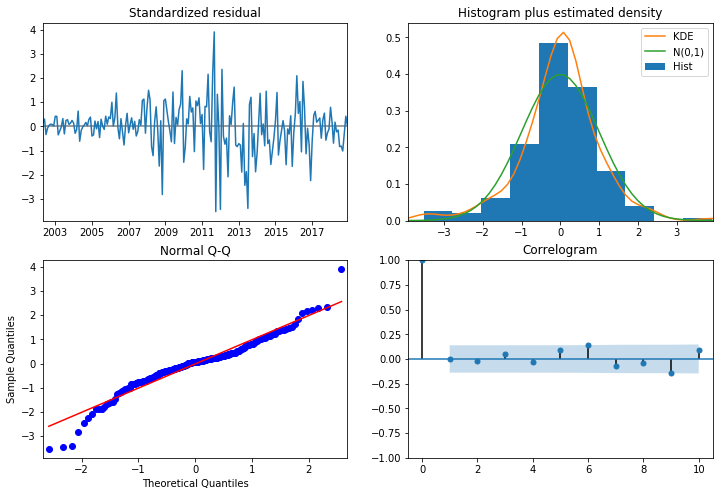

In [44]:
model_results.plot_diagnostics(figsize=(12, 8));

In [49]:
model_results.resid.describe()

count    227.000000
mean       0.139209
std       57.374069
min     -196.799149
25%      -22.359399
50%        3.450682
75%       22.796552
max      283.200000
dtype: float64

## Predicting the model

In [51]:
n = len(df_settle.index)
prediction = model_results.get_prediction(
    start=n-12*5, 
    end=n+5
)
prediction_ci = prediction.conf_int()

In [52]:
print(prediction_ci.head(3))

            lower Settle  upper Settle
2014-01-01   1154.104344   1370.905747
2014-02-01   1122.193099   1338.994313
2014-03-01   1137.423587   1354.207988


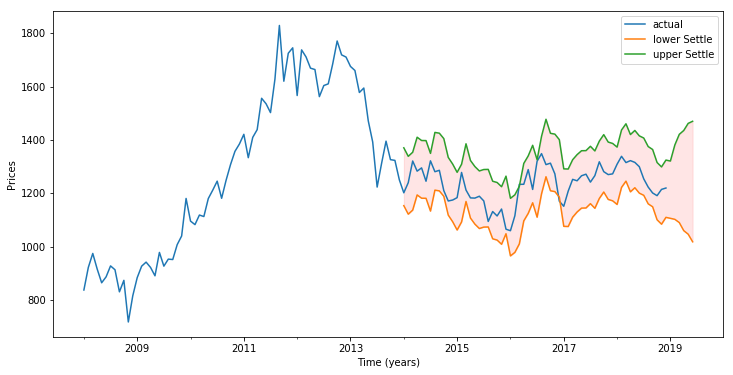

In [54]:
plt.figure(figsize=(12, 6))

ax = df_settle['2008':].plot(label='actual')
prediction_ci.plot(
    ax=ax, style=['--', '--'],
    label='predicted/forecasted')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci,
    color='r', alpha=.1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()